<a href="https://colab.research.google.com/github/weitzelleila/hate-offensive-analysis/blob/master/rnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read non balanced data


In [0]:
import pandas as pd
trainDF = pd.read_csv('/content/drive/My Drive/TCC/proc_NB.csv',index_col=1).drop(['Unnamed: 0'],axis=1)
trainDF.groupby('label').count()

trainDF.label = [1 if label == "hatetag" else 0 for label in trainDF.label] 

# Split data

In [0]:
from sklearn import model_selection, preprocessing
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# Word Embeddings

In [0]:
from numpy import asarray, zeros
from keras.preprocessing import text, sequence

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/content/drive/My Drive/TCC/cbow_s50_filtrado.txt')):
    values = line.split()
    embeddings_index[values[0]] = asarray(values[1:], dtype='float32')
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=100)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=100)

# create token-embedding mapping
embedding_matrix = zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# BERT

# LSTM

In [0]:
from sklearn import metrics
from keras import layers, models, optimizers

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label,epochs=1)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        with open('/content/drive/My Drive/TCC/predictions.txt','w') as f:
          predictions.tofile(f,sep="\n",format="%s")
    return predictions

def create_rnn_lstm():
  # Add an Input Layer
  input_layer = layers.Input((100, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(len(word_index) + 1, 50, weights=[embedding_matrix], trainable=False)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the LSTM Layer
  lstm_layer = layers.LSTM(100)(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc', 'mae'])
  return model

classifier = create_rnn_lstm()
predictions = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  metrics.accuracy_score(predictions,valid_y)



Epoch 1/1
24382/24382 [==============================] - 60s 2ms/step - loss: 0.3525 - acc: 0.8742 - mae: 0.2068
RNN-LSTM, Word Embeddings 0.8777066929133859


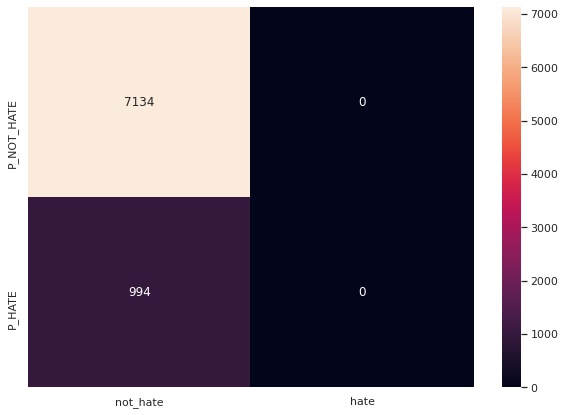

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
from numpy import int


cm = metrics.confusion_matrix(valid_y,predictions)
df_cm = pd.DataFrame(cm,['P_NOT_HATE','P_HATE'], ['not_hate','hate'])
plt.figure(figsize=(10,7))
sn.set(font_scale=1)# for label size
sn.heatmap(df_cm, annot=True,fmt='d') # font size

plt.show()

# New Section